<a href="https://colab.research.google.com/github/varunkr24/Machine-Learning/blob/Python/BM_propensity_preprocessing_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### importing libraries and data

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import lightgbm as lgb
from datetime import date
import pyodbc
import math
import warnings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [ ]:
# # #Loading the data from model table in SQL Server

# sql_conn = pyodbc.connect("DSN=CNPPEDW05")

# sql = "select * from EDW.DTCStage.SKB001_BM_FinalModelData"

# df = pd.read_sql(sql, sql_conn)

# df.shape

In [ ]:
# df.to_csv('BM_Call_Routing_ModelingData_11_10_2021.csv',index=False)

In [ ]:
df = pd.read_csv('BM_Call_Routing_ModelingData_11_10_2021.csv')
df.shape

(2374105, 152)

In [ ]:
df.head()

,LeadID,BorrowerDimID,CampaignID,CRMID,LeadDate,CallTimeType,TriggerDate,LeadSourceId,FirstName,LastName,HomePhone,WorkPhone,MobilePhone,PrimaryPhone,FilterName,FilterRoutingID,PrimaryEmail,DesiredLoanPurpose,DesiredNewLoanAmount,LendingTreeTrackingNumber,PropertyAddress,PropertyAddress2,PropertyCity,PropertyCounty,PropertyState,PropertyZipCode,SocialSecurityNumber,DateofBirth,CreatedOn,LeadSource,UnpaidPrincipalBalance,MailingState,CurrentPropertyValue,PropertyUse,PropertyPurchasePrice,TargetCashoutAmount,AssignedCreditValue,SelfCreditRating,Bankruptcy,Foreclosure,LoanRequestType,DownPayment,SecondMortgageBalance,PresentLTV,PresentCLTV,ProposedLTV,ProposedCLTV,RequestType,EmploymentStatus,ResidenceType,IsWorkingWithAgent,IsFoundHome,IsFHAEligible,IsVALoan,IsMilitary,IsSFXSystem,IsPrimaryEmailValid,CustomerRegistryID,ISExistingCustomerRelationship,ServicingLoanNumber,CustomerPhoneNumber,CallStartDateTime,calls_LoanNumSrvcr,OriginatingContactID,IsLCConversation,IsAnswered,MktgLeadType,CustomerType,CampaignSourceType,CampaignCategory,LeadFact_CampaignName,LoanNumSrvcr,XferFlag,LCConversation,CreditInqFlag,InitialLockDate,LockFlag,STUFlag,CCSAgentName,CCSAgentID,LCName,LCID,LCTeam,PropState,CreditOrderDate,STUDate,FundFlag,FundDate,contactflag,Min_LockDt,Min_CreditDt,Min_STUDt,Min_FundDt,Row_Nbr,Lock,Infutor,Phone Type,Demographic Level,Penetration Range Other Occupation,Penetration Range Blue Collar,Penetration Range White Collar,Median Years of School,Percent Range Automobile Owner,Mail Order Respondent,Median House Value,Percent Range MFDU,Percentage Range SFDU,Percent Range Asian Speaking,Percentage Range Spanish Speaking,Percent Range English Speaking,Percent Range Asian,Percent Range Hispanic,Percent Range White,Percent Range Black,Home Market Value,Median Year Built,Marital Status,Dwelling Type,Estimated Household Income,Wealth Score,Homeowner,Length of Residence,Age_INF,Gender,Mortgage Term,Mortgage Deed Type,Mortgage Type,Mortgage Amount,Loan To Value,Sale Type,Last Assessment Year,Deed Type,Tax Year,Tax Amount,Number of Bathrooms,Living Squarefeet,Square foot type indicator,Land Squarefeet,Year Built,Improvement Value Indicator,Number of Stories in Building,Number of Buildings,Property Type Indicator,Residential Based,Absentee Owner Indicator,Land Use code,Mortgage Due Date,Mortgage Date,Recording Date,ReferenceNumber,ID Verify Score,RecordNum
0,500707,1208461,783,00Q3m000012HVklEAG,2021-06-19,Off Hours,2021-06-18 00:00:00.000,2.0,Adrian,Kanten,7.632490e+09,NaN,NaN,7.632490e+09,LF Refi $125k+ Rate/Term 680+,894918.0,NaN,REFIPRIMARY,130000.0,577566856,MN 55434,NaN,MINNEAPOLIS,ANOKA,MN,55434,468029320.0,1972-09-29,2021-06-18 21:47:10.777,Lending Tree,130000.0,MN,325000.0,OWNEROCCUPIED,325000.0,NaN,779.0,EXCELLENT,NEVER,NEVER,REFINANCE,NaN,0.0,40.0000,40.0000,40.0000,40.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1,5037708,False,NaN,7.632490e+09,2021-09-07 15:33:40.000,NaN,1.657690e+11,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Infutor,W,1.0,N,T,H,143.0,C,G,D,NaN,A,NaN,NaN,C,T,S,D,S,H,1921.0,M,S,F,NaN,H,7.0,52.0,M,20.0,MG,CNV,167600.0,50.0,1.0,2019.0,G,2019.0,307078.0,300.0,2065.0,L,10325.0,1981.0,M,100.0,1.0,10.0,Y,O,163.0,2036-06-01,2016-05-23,2005-08-26,1208461,79,1
1,408375,1112077,783,00Q3l00000xzAryEAE,2021-02-01,Business Hours,2021-02-01 00:00:00.000,2.0,John,Anderson,9.132549e+09,NaN,NaN,9.132549e+09,LF Refi $125k+ Rate/Term 680+,894918.0,NaN,REFIPRIMARY,150000.0,571571704,KS 66062,NaN,OLATHE,JOHNSON,KS,66062,441701945.0,1968-03-01,2021-02-01 10:19:24.893,Lending Tree,150000.0,KS,275000.0,OWNEROCCUPIED,275000.0,NaN,769.0,EXCELLENT,NEVER,NEVER,REFINANCE,NaN,0.0,54.5455,54.5455,54.5455,54.5455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1,4760766,False,NaN,9.132549e+09,2021-02-01 10:19:28.000,NaN,1.336405e+11,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Infutor,L,1.0,L,S,J,1

In [ ]:
df['LeadID'].nunique()

249291

In [ ]:
df['LeadDate'].min(), df['LeadDate'].max()

('2019-06-01', '2021-11-05')

In [ ]:
df = df[df['LeadDate'] >= '2020-01-01']
df.shape

(2249076, 152)

In [ ]:
df.shape

(2249076, 152)

In [ ]:
df['LeadDate'].min(), df['LeadDate'].max()

('2020-01-01', '2021-11-05')

In [ ]:
df['LeadID'].nunique()

187921

In [ ]:
final_model_cols= ['LeadID','ID Verify Score', 'Mortgage Deed Type', 'Mortgage Type',
       'Penetration Range Blue Collar', 'Penetration Range Other Occupation',
       'Penetration Range White Collar', 'Percent Range Automobile Owner',
       'Home Market Value', 'Dwelling Type', 'Estimated Household Income',
       'Loan To Value', 'Land Squarefeet', 'Improvement Value Indicator',
       'Property Type Indicator', 'Absentee Owner Indicator',
       'Square foot type indicator', 'Wealth Score', 'Year Built',
       'DesiredNewLoanAmount', 'CurrentPropertyValue', 'Bankruptcy',
       'LoanRequestType', 'IsMilitary', 'SelfCreditRating',
       'UnpaidPrincipalBalance', 'Mortgage Amount']
len(final_model_cols)

27

In [ ]:
original_features = ['LeadID',
 'ID Verify Score',
 'DesiredNewLoanAmount',
 'UnpaidPrincipalBalance',
 'CurrentPropertyValue',
 'IsMilitary',
 'Demographic Level',
 'Median Years of School',
 'Median Year Built',
 'Length of Residence',
 'Mortgage Amount',
 'Loan To Value',
 'Sale Type',
 'Tax Amount',
 'Number of Bathrooms',
 'Living Squarefeet',
 'Land Squarefeet',
 'Year Built',
 'PropertyState',
 'LeadSource',
 'CampaignID',
 'Bankruptcy',
 'LoanRequestType',
 'Phone Type',
 'Mail Order Respondent',
 'Median House Value',
 'Dwelling Type',
 'Homeowner',
 'Mortgage Term',
 'Mortgage Deed Type',
 'Mortgage Type',
 'Last Assessment Year',
 'Deed Type',
 'Tax Year',
 'Square foot type indicator',
 'Improvement Value Indicator',
 'Number of Stories in Building',
 'Number of Buildings',
 'Property Type Indicator',
 'Residential Based',
 'Absentee Owner Indicator',
 'Land Use code',
 'Penetration Range Blue Collar',
 'Penetration Range Other Occupation',
 'Penetration Range White Collar',
 'Percent Range Automobile Owner',
 'Home Market Value',
 'Estimated Household Income',
 'Wealth Score',
 'SelfCreditRating',
 'Mortgage Due Date',
 'Mortgage Date',
 'Recording Date']

In [ ]:
len(original_features)

53

In [ ]:
df1 = df[original_features].drop_duplicates()
df1.shape

(187921, 53)

In [ ]:
df2 = df[['LeadID','Lock']]
df2 = df2.replace(np.nan, 0)
df2 = df2.drop_duplicates()
df2.shape

(190895, 2)

In [ ]:
df1_lock = df2.groupby('LeadID').agg({'Lock':'sum'}).reset_index()
df1_lock.shape

(187921, 2)

In [ ]:
df = pd.merge(df1, df1_lock, how='inner', on = 'LeadID')
df.shape

(187921, 54)

In [ ]:
df.to_csv('BM_Propensity_Data_for_call_routing_11_10_21.csv',index=False)

In [ ]:
# df.to_csv('BM_Call_Routing_ModelingData_final_11_09.csv',index=False)

In [ ]:
# df = pd.read_csv('BM_Call_Routing_ModelingData_final_11_09.csv')
# df.shape

In [ ]:
df['Bankruptcy'].value_counts()

NEVER             82006
UNKNOWN           62866
Never              6200
no                 3362
OVER_72_MONTHS      249
37-48_MONTHS        246
49-60_MONTHS        162
61-72_MONTHS        159
years2_5             72
01-12_Months         14
yes_in_7              2
years1_2              1
Name: Bankruptcy, dtype: int64

In [ ]:
df['Bankruptcy'].value_counts(normalize=True)

NEVER             0.527916
UNKNOWN           0.404702
Never             0.039913
no                0.021643
OVER_72_MONTHS    0.001603
37-48_MONTHS      0.001584
49-60_MONTHS      0.001043
61-72_MONTHS      0.001024
years2_5          0.000464
01-12_Months      0.000090
yes_in_7          0.000013
years1_2          0.000006
Name: Bankruptcy, dtype: float64

In [ ]:
df.groupby('Bankruptcy').agg({'LeadID':'count','Lock':'sum'}).reset_index()

,Bankruptcy,LeadID,Lock
0,01-12_Months,14,0.0
1,37-48_MONTHS,246,1.0
2,49-60_MONTHS,162,0.0
3,61-72_MONTHS,159,2.0
4,NEVER,82006,589.0
5,Never,6200,18.0
6,OVER_72_MONTHS,249,3.0
7,UNKNOWN,62866,2176.0
8,no,3362,87.0
9,years1_2,1,0.0


In [ ]:
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
df.head()

,LeadID,ID Verify Score,DesiredNewLoanAmount,UnpaidPrincipalBalance,CurrentPropertyValue,IsMilitary,Demographic Level,Median Years of School,Median Year Built,Length of Residence,Mortgage Amount,Loan To Value,Sale Type,Tax Amount,Number of Bathrooms,Living Squarefeet,Land Squarefeet,Year Built,PropertyState,LeadSource,CampaignID,Bankruptcy,LoanRequestType,Phone Type,Mail Order Respondent,Median House Value,Dwelling Type,Homeowner,Mortgage Term,Mortgage Deed Type,Mortgage Type,Last Assessment Year,Deed Type,Tax Year,Square foot type indicator,Improvement Value Indicator,Number of Stories in Building,Number of Buildings,Property Type Indicator,Residential Based,Absentee Owner Indicator,Land Use code,Penetration Range Blue Collar,Penetration Range Other Occupation,Penetration Range White Collar,Percent Range Automobile Owner,Home Market Value,Estimated Household Income,Wealth Score,SelfCreditRating,Mortgage Due Date,Mortgage Date,Recording Date,Lock
0,500707,79,130000.0,130000.0,325000.0,False,1.0,143.0,1921.0,7.0,167600.0,50.0,1.0,307078.0,300.0,2065.0,10325.0,1981.0,MN,Lending Tree,783,NEVER,REFINANCE,W,G,D,S,H,20.0,MG,CNV,2019.0,G,2019.0,L,M,100.0,1.0,10.0,Y,O,163.0,T,N,H,C,H,F,NaN,EXCELLENT,2036-06-01,2016-05-23,2005-08-26,0.0
1,408375,79,150000.0,150000.0,275000.0,False,1.0,152.0,NaN,8.0,161600.0,61.0,1.0,332419.0,300.0,1791.0,9126.0,1996.0,KS,Lending Tree,783,NEVER,REFINANCE,L,I,D,M,H,30.0,MG,CNV,2020.0,Q,2019.0,L,P,100.0,1.0,10.0,Y,O,163.0,S,L,J,J,NaN,E,NaN,EXCELLENT,2050-08-01,2020-07-23,2016-03-17,0.0
2,394686,72,160000.0,160000.0,350000.0,False,1.0,136.0,1980.0,6.0,239000.0,82.0,1.0,714200.0,300.0,2256.0,47480.0,1980.0,CT,Lending Tree,783,NEVER,REFINANCE,W,F,E,S,H,30.0,NaN,CNV,2019.0,G,2019.0,L,A,200.0,1.0,10.0,Y,O,163.0,NaN,NaN,M,A,M,H,G,SOMECREDITPROBLEMS,2033-01-01,2003-11-20,2007-01-11,0.0
3,238278,81,270000.0,270000.0,300000.0,False,1.0,141.0,1985.0,10.0,164500.0,59.0,2.0,118020.0,300.0,1381.0,44.0,1985.0,NV,LMB,511,Never,Refinance,W,K,E,S,H,30.0,TR,CNV,2019.0,G,2019.0,L,A,200.0,1.0,11.0,Y,O,112.0,S,N,I,A,E,G,E,Excellent,2047-09-01,2017-08-24,2013-01-08,0.0
4,387004,69,140000.0,140000.0,250000.0,False,2.0,104.0,1986.0,8.0,156000.0,90.0,1.0,328010.0,300.0,1661.0,25265.0,1986.0,OH,Lending Tree,783,NEVER,REFINANCE,W,H,C,S,H,30.0,MG,CNV,2019.0,G,2019.0,L,M,100.0,1.0,10.0,Y,O,163.0,R,I,N,A,G,C,F,EXCELLENT,2048-08-01,2018-07-20,2018-07-23,0.0


In [ ]:
df['Sale Type'].value_counts()

1.0    105367
9.0     19917
3.0     17536
2.0      7652
6.0       977
7.0       609
Name: Sale Type, dtype: int64

In [ ]:
sum(df['Sale Type'].isnull())

35863

In [ ]:
#preprocessing Number of Buildings
def Preprocess_Number_of_Buildings(x):
    try:
        if float(x) < 3:
            return x
        elif float(x) >=3:
            return '>2'
        else:
            return 'UNKNOWN'
    except:
        return 'UNKNOWN'

In [ ]:
df = df.replace(np.nan, '')

In [ ]:
#date_cols
date_cols = ['Mortgage Due Date', 'Mortgage Date', 'Recording Date']

In [ ]:
df[date_cols].dtypes

Mortgage Due Date    object
Mortgage Date        object
Recording Date       object
dtype: object

In [ ]:
df[date_cols] = df[date_cols].astype('str')

In [ ]:
df[date_cols].head()

,Mortgage Due Date,Mortgage Date,Recording Date
0,2036-06-01,2016-05-23,2005-08-26
1,2050-08-01,2020-07-23,2016-03-17
2,2033-01-01,2003-11-20,2007-01-11
3,2047-09-01,2017-08-24,2013-01-08
4,2048-08-01,2018-07-20,2018-07-23


In [ ]:
def str_date(x):
    yyyy = x[0:4]
    MM = x[5:7]
    DD = x[8:10]
    return yyyy+MM+DD

In [ ]:
for col in date_cols:
    df[col] = df[col].apply(str_date)

In [ ]:
df[date_cols].head()

,Mortgage Due Date,Mortgage Date,Recording Date
0,20360601,20160523,20050826
1,20500801,20200723,20160317
2,20330101,20031120,20070111
3,20470901,20170824,20130108
4,20480801,20180720,20180723


In [ ]:
original_features = ['LeadID',
 'ID Verify Score',
 'DesiredNewLoanAmount',
 'UnpaidPrincipalBalance',
 'CurrentPropertyValue',
 'IsMilitary',
 'Demographic Level',
 'Median Years of School',
 'Median Year Built',
 'Length of Residence',
 'Mortgage Amount',
 'Loan To Value',
 'Sale Type',
 'Tax Amount',
 'Number of Bathrooms',
 'Living Squarefeet',
 'Land Squarefeet',
 'Year Built',
 'PropertyState',
 'LeadSource',
 'CampaignID',
 'Bankruptcy',
 'LoanRequestType',
 'Phone Type',
 'Mail Order Respondent',
 'Median House Value',
 'Dwelling Type',
 'Homeowner',
 'Mortgage Term',
 'Mortgage Deed Type',
 'Mortgage Type',
 'Last Assessment Year',
 'Deed Type',
 'Tax Year',
 'Square foot type indicator',
 'Improvement Value Indicator',
 'Number of Stories in Building',
 'Number of Buildings',
 'Property Type Indicator',
 'Residential Based',
 'Absentee Owner Indicator',
 'Land Use code',
 'Penetration Range Blue Collar',
 'Penetration Range Other Occupation',
 'Penetration Range White Collar',
 'Percent Range Automobile Owner',
 'Home Market Value',
 'Estimated Household Income',
 'Wealth Score',
 'SelfCreditRating',
 'Mortgage Due Date',
 'Mortgage Date',
 'Recording Date']

In [ ]:
num_cols = ['LeadID',
 'ID Verify Score',
 'DesiredNewLoanAmount',
 'UnpaidPrincipalBalance',
 'CurrentPropertyValue',
 'Demographic Level',
 'Median Years of School',
 'Median Year Built',
 'Length of Residence',
 'Mortgage Amount',
 'Loan To Value',
#  'Sale Type',
 'Tax Amount',
 'Number of Bathrooms',
 'Living Squarefeet',
 'Land Squarefeet',
 'Year Built']

 #cat_cols
cat_cols = ['PropertyState',
 'IsMilitary',
 'LeadSource',
 'CampaignID',
 'SelfCreditRating',
 'Bankruptcy',
 'LoanRequestType',
 'Phone Type',
 'Penetration Range Other Occupation',
 'Penetration Range Blue Collar',
 'Penetration Range White Collar',
 'Percent Range Automobile Owner',
 'Mail Order Respondent',
 'Median House Value',
 'Home Market Value',
 'Wealth Score',
 'Dwelling Type',
 'Estimated Household Income',
 'Homeowner',
 'Mortgage Term',
 'Mortgage Deed Type',
 'Mortgage Type',
 'Last Assessment Year',
 'Deed Type',
 'Tax Year',
 'Square foot type indicator',
 'Improvement Value Indicator',
 'Number of Stories in Building',
 'Number of Buildings',
 'Property Type Indicator',
 'Residential Based',
 'Absentee Owner Indicator',
 'Land Use code', 
 'Demographic Level',
 'Sale Type']



#date_cols
date_cols = ['Mortgage Due Date', 'Mortgage Date', 'Recording Date']

#outlier_cols
outlier_cols = ['DesiredNewLoanAmount', 'UnpaidPrincipalBalance', 'CurrentPropertyValue', 'Median Years of School', 'Median Year Built', 'Length of Residence', 'Mortgage Amount', 'Loan To Value', 'Tax Amount', 'Number of Bathrooms', 'Living Squarefeet', 'Land Squarefeet', 'Year Built']

#ordinal_cat_cols
ordinal_cols = ['Penetration Range Blue Collar',
 'Penetration Range Other Occupation',
 'Penetration Range White Collar',
 'Percent Range Automobile Owner',
 'Home Market Value',
 'Estimated Household Income',
 'Wealth Score',
 'SelfCreditRating']

In [ ]:
df.shape

(187921, 54)

### classes

In [ ]:
#class to get required columns only
from sklearn.base import BaseEstimator, TransformerMixin

class get_needed_columns(BaseEstimator, TransformerMixin):
    
    def __init__(self, original_features):
        self.original_features = original_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.replace('',np.nan)
        return X[original_features]

In [ ]:
class ColumnTypeChange_Imputation(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_cols, cat_cols):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        X[self.num_cols] = X[self.num_cols].astype('float64')#.fillna(-999)
        X[self.cat_cols] = X[self.cat_cols].apply(lambda x: x.astype(str).str.upper()).astype('object')
        return X

In [ ]:
#preprocessing Bankruptcy
def Preprocess_Bankruptcy(x):

    bankruptcy_yes = ['01-12_MONTHS','13-24_MONTHS','25-36_MONTHS','37-48_MONTHS','49-60_MONTHS','61-72_MONTHS','OVER_72_MONTHS']
    bankruptcy_never = ['NEVER','UNKNOWN']
    #either yes or never or unknown
    if x in bankruptcy_yes:
        return 'YES'
    else:
        return 'NEVER'
#preprocessing Number of Buildings
def Preprocess_Number_of_Buildings(x):
    try:
        if float(x) < 3:
            return x
        elif float(x) >=3:
            return '>2'
        else:
            return 'UNKNOWN'
    except:
        return 'UNKNOWN'

#preprocessing Property Type Indicator
def Preprocess_Property_Type_Indicator(x):
    try:
        if float(x)==10:
            return '10'
        elif float(x) > 10:
            return '>10'
        else:
            return 'UNKNOWN'
    except:
        return 'UNKNOWN'

#preprocessing Number of stories in building
def Preprocess_Number_of_stories_in_Building(x):
    try:
        if float(x)==100:
            return '100'
        elif float(x)==200:
            return '200'
        elif float(x)>200:
            return '>200'
        elif float(x)>100:
            return '100-200'
        else:
            return 'UNKNOWN'
    except:
        return 'UNKNOWN'

#preprocessing Mortgage term
def Preprocess_Mortgage_Term(x):
    try:
        if float(x)<=15:
            return '15'
        elif float(x)>=30:
            return '30'
        elif float(x)>20:
            return '>20'
        elif float(x)>15:
            return '15_20'
        else:
            return 'UNKNOWN'
    except:
        return 'UNKNOWN'

In [ ]:
class preprocess_columns(BaseEstimator, TransformerMixin):
    
    def __init__(self,Bankruptcy,Number_of_Buildings,Property_Type_Indicator,Number_of_Stories_in_Building,Mortgage_Term):
        self.Bankruptcy = Bankruptcy
        self.Number_of_Buildings = Number_of_Buildings
        self.Property_Type_Indicator = Property_Type_Indicator
        self.Number_of_Stories_in_Building = Number_of_Stories_in_Building
        self.Mortgage_Term = Mortgage_Term
    
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        X[self.Bankruptcy] = X[self.Bankruptcy].apply(Preprocess_Bankruptcy)
        X[self.Number_of_Buildings] = X[self.Number_of_Buildings].apply(Preprocess_Number_of_Buildings)
        X[self.Property_Type_Indicator] = X[self.Property_Type_Indicator].apply(Preprocess_Property_Type_Indicator)
        X[self.Number_of_Stories_in_Building] = X[self.Number_of_Stories_in_Building].apply(Preprocess_Number_of_stories_in_Building)
        X[self.Mortgage_Term] = X[self.Mortgage_Term].apply(Preprocess_Mortgage_Term)
        return X

In [ ]:
class outlier_removal(BaseEstimator, TransformerMixin):
    
    def __init__(self,num_cols):
        self.num_cols = num_cols
    
    def fit(self, X, y=None):
        self.outlier_dict = {}
        for feature in self.num_cols:
            self.outlier_dict[feature] = X[feature].quantile([0.05,0.95]).values
        return self
    
    def transform(self, X):
        for feature in self.num_cols:
            X.loc[X[feature] <= self.outlier_dict.get(feature)[0],feature] = self.outlier_dict.get(feature)[0]
            X.loc[X[feature] >= self.outlier_dict.get(feature)[1],feature] = self.outlier_dict.get(feature)[1]
        return X

In [ ]:
def get_cat_list(df,col):
    cat_list = []
    list_cat = list(df[col].unique())
    for cat in list_cat:
        if len(df[df[col]==cat]) >= 100:
            cat_list.append(cat)
    return cat_list

In [ ]:
class minor_cat(BaseEstimator, TransformerMixin):
    
    def __init__(self,cat_cols):
        self.cat_cols = cat_cols
    
    def fit(self, X, y=None):
        self.cat_dict = {}
        for feature in self.cat_cols:
            self.cat_dict[feature] = get_cat_list(X,feature)
        return self
    
    def transform(self, X):
        for feature in self.cat_cols:
            X.loc[~(X[feature].isin(self.cat_dict.get(feature))),feature] = 'OTHERS'
        return X

In [ ]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

import re
def generate_date_features(df, fldname):
    fld = df[fldname]
    fld_dtype = fld.dtype
    df[fldname] = df[fldname].astype('str')

    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Dayofweek',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre+"Is_weekend"]=df[targ_pre+"Dayofweek"].apply(lambda x:1 if x==5 or x==6 else 0)
    df.loc[df[fldname].notnull(),targ_pre+"Week_of_month"] = df[df[fldname].notnull()][fldname].apply(week_of_month)
    df.loc[df[fldname].notnull(),targ_pre+"Decade"] = df[df[fldname].notnull()][targ_pre+'Year'].apply(lambda x: int(x/10))
    df.drop(targ_pre+'Year',axis=1,inplace=True)
    df.drop(fldname, axis=1, inplace=True)
    return df

In [ ]:
class date_transform(BaseEstimator, TransformerMixin):
    
    def __init__(self,date_cols):
        self.date_cols = date_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for feature in self.date_cols:
            X = generate_date_features(X,feature)
        return X

In [ ]:
import re
import scipy.stats as ss

def ordinal_rank_SCR(df):
    values = ['EXCELLENT','SOMECREDITPROBLEMS','GOOD','MAJORCREDITPROBLEMS','LITTLEORNOCREDITHISTORY']
    ranks = [5,2,4,1,3]
    return(dict(zip(values, ranks)))


def ordinal_rank_asc(df,col):
    values = list(df[col].unique())
    if 'NONE' in values:
        values.remove('NONE')
    if 'NAN' in values:
        values.remove('NAN')
    int_list = []
    for val in values:
        if val == 'OTHERS':
            int_list.append(ord('Z'))
        else:
            int_list.append(ord(val))
    ranks = ss.rankdata(int_list)
    return(dict(zip(values, ranks)))
    
def ordinal_rank_desc(df,col):
    values = list(df[col].unique())
    if 'NONE' in values:
        values.remove('NONE')
    if 'NAN' in values:
        values.remove('NAN')
    int_list = []
    for val in values:
        if val == 'OTHERS':
            int_list.append(ord('Z'))
        else:
            int_list.append(ord(val))
    ranks = ss.rankdata([-1*i for i in int_list])
    return(dict(zip(values, ranks)))

In [ ]:
class ordinal_cat(BaseEstimator, TransformerMixin):
    
    def __init__(self,self_credit_rating,ordinal_asc,ordinal_desc):
        self.self_credit_rating = self_credit_rating
        self.ordinal_asc = ordinal_asc
        self.ordinal_desc = ordinal_desc
    
    def fit(self, X, y=None):
        self.rank_sfc = ordinal_rank_SCR(X)
        self.rank_asc = {}
        self.rank_desc = {}
        for feature in self.ordinal_asc:
            self.rank_asc[feature] = ordinal_rank_asc(X,feature)
        for feature in self.ordinal_desc:
            self.rank_desc[feature] = ordinal_rank_desc(X,feature)
        return self
    
    def transform(self, X):
        X['self_credit_rating_ordinal'] = X[self.self_credit_rating].apply(lambda x: self.rank_sfc.get(x))
        X['self_credit_rating_ordinal'] = X['self_credit_rating_ordinal'].replace('None',np.nan).astype('float')
        for feature in self.ordinal_asc:
            X[feature+'_ordinal'] = X[feature].apply(lambda x: self.rank_asc.get(feature).get(x))
            X[feature+'_ordinal'] = X[feature+'_ordinal'].replace('NAN',np.nan)
            X[feature+'_ordinal'] = X[feature+'_ordinal'].replace('NONE',np.nan).astype('float')
        for feature in self.ordinal_desc:
            X[feature+'_ordinal'] = X[feature].apply(lambda x: self.rank_desc.get(feature).get(x))
            X[feature+'_ordinal'] = X[feature+'_ordinal'].replace('NAN',np.nan)
            X[feature+'_ordinal'] = X[feature+'_ordinal'].replace('NONE',np.nan).astype('float')
        return X

In [ ]:
class mean_imputation(BaseEstimator, TransformerMixin):
    
    def __init__(self,mean_impute):
        self.mean_impute = mean_impute
        
    def fit(self, X, y=None):
        self.dict_mean = {}
        for feature in self.mean_impute:
            self.dict_mean[feature] = X[feature].mean()
        return self
    
    def transform(self, X):
        X = X.copy()
        for feature in self.mean_impute:
            X[feature].fillna(self.dict_mean.get(feature),inplace=True)   
        return X

In [ ]:
class cat_imputation(BaseEstimator, TransformerMixin):
    
    def __init__(self,mode,non_mode,bool_cols):
        self.mode = mode
        self.non_mode = non_mode
        self.bool_cols = bool_cols
        
    def fit(self, X, y=None):
        self.dict_mode = {}
        self.dict_bool = {}
        for feature in self.mode:
            self.dict_mode[feature] = X[feature].mode()[0]
        return self
    
    def transform(self, X):
        for feature in self.mode:
            X[feature] = X[feature].replace('NAN',self.dict_mode.get(feature))
            X[feature] = X[feature].replace('NONE',self.dict_mode.get(feature))   
        for feature in self.non_mode:
            X[feature] = X[feature].replace('NAN','UNKNOWN')
            X[feature] = X[feature].replace('NONE','UNKNOWN')
        for feature in self.bool_cols:
            X[feature] = X[feature].replace(np.nan,self.dict_mode.get(feature))
            X[feature] = X[feature].astype('int')
        return X

In [ ]:
def calc_smooth_mean(df, by, on, m):
    mean = df[on].mean()
    agg = df.groupby(by)[on].agg(['count','mean'])
    counts = agg['count']
    means = agg['mean']
    smooth = (counts*means+m*mean)/(counts+m)
    return smooth

In [ ]:
class target_encoding(BaseEstimator, TransformerMixin):
    
    def __init__(self,cat_cols):
        #self.target = target
        self.cat_cols = cat_cols
        
    def fit(self, X, y):
        X['target'] = y
        self.dict_target = {}
        for feature in self.cat_cols:
            self.dict_target[feature] = calc_smooth_mean(X,feature,'target',1000)
        return self
    
    def transform(self, X):
        for feature in self.cat_cols:
            X[feature] = X[feature].map(self.dict_target.get(feature)*100)
        return X

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
class final_model(BaseEstimator, TransformerMixin):
    
    def __init__(self,params=None):
        None
        
    def fit(self, X, y):
        self.total_cols = X.columns.to_list()
        self.total_cols.remove('LeadID')
        self.total_cols.remove('ID Verify Score')
        self.total_cols.remove('target')
        self.processed_columns = [l.replace(" ","_") for l in self.total_cols]
        X = X[self.total_cols]
        X.columns = self.processed_columns
        lgbm = LGBMClassifier(n_estimators=845,
                             metric=  'auc',
                             max_depth= 5,
                             learning_rate= 0.10244824551149534,
                             min_data_in_leaf= 80,
                             num_leaves= 38,
                             bagging_fraction= 0.856958665167685,
                             feature_fraction= 0.3086053447141449,
                             is_unbalance= True,
                             bagging_freq= 8,
                             bagging_seed= 12345,
                             lambda_l1 = 0.5879295423261183,
                             lambda_l2 = 1.8924148301563073,
                             min_split_gain = 0.07321862315023188,
                             min_child_weight = 37.67028128497241)
        self.lgbm_model = lgbm.fit(X[self.processed_columns],y)       
        return self
    
    def transform(self, X):
        X = X.copy()
        X_id_verify_score = X[X['ID Verify Score'] < 60]
        pred_id_verify_score = pd.DataFrame({'LeadID': X_id_verify_score['LeadID'], 'propensity': 0})
        X_remaining = X[X['ID Verify Score'] >=60] 
        self.leads = X_remaining['LeadID']
        X_remaining = X_remaining[self.total_cols]
        X_remaining.columns = self.processed_columns
        if len(X_remaining) > 0:
            probs = self.lgbm_model.predict_proba(np.array(X_remaining[self.processed_columns]))
            probs = [x[1] for x in probs]
            pred_remaining = pd.DataFrame({'LeadID': self.leads, 'propensity': probs})
            total_pred_df = pd.concat([pred_id_verify_score, pred_remaining], ignore_index=True)
        else:
            total_pred_df = pred_id_verify_score
        return total_pred_df


In [ ]:
# {'bagging_fraction': 0.909762700785465,
#  'bagging_freq': 7.436704297351775,
#  'feature_fraction': 0.5822107008573151,
#  'lambda_l1': 2.724415914984484,
#  'lambda_l2': 1.270964398016714,
#  'learning_rate': 0.6458941130666561,
#  'max_depth': 6.7459729729381435,
#  'min_child_weight': 45.12978503519359,
#  'min_data_in_leaf': 194.5494140751544,
#  'min_split_gain': 0.038960710363751996,
#  'num_iterations': 3960.7079400324965,
#  'num_leaves': 35.10679331481099}

In [ ]:
# import lightgbm as lgb
# from lightgbm import LGBMClassifier
# class final_model(BaseEstimator, TransformerMixin):
    
#     def __init__(self,params=None):
#         None
        
#     def fit(self, X, y):
#         self.total_cols = X.columns.to_list()
#         self.total_cols.remove('LeadID')
#         self.total_cols.remove('ID Verify Score')
#         self.total_cols.remove('target')
#         self.processed_columns = [l.replace(" ","_") for l in self.total_cols]
#         X = X[self.total_cols]
#         X.columns = self.processed_columns
#         lgbm = LGBMClassifier(n_estimators=3960,
#                              metric=  'auc',
#                              max_depth= 6,
#                              learning_rate= 0.64,
#                              min_data_in_leaf= 194,
#                              num_leaves= 35,
#                              bagging_fraction= 0.90,
#                              feature_fraction= 0.58,
#                              is_unbalance= True,
#                              bagging_freq= 7,
#                              bagging_seed= 12345,
#                              lambda_l1 = 2.72,
#                              lambda_l2 = 1.27,
#                              min_split_gain = 0.038,
#                              min_child_weight = 45.12)
#         self.lgbm_model = lgbm.fit(X[self.processed_columns],y)       
#         return self
    
#     def transform(self, X):
#         X = X.copy()
#         X_id_verify_score = X[X['ID Verify Score'] < 60]
#         pred_id_verify_score = pd.DataFrame({'LeadID': X_id_verify_score['LeadID'], 'propensity': 0})
#         X_remaining = X[X['ID Verify Score'] >=60] 
#         self.leads = X_remaining['LeadID']
#         X_remaining = X_remaining[self.total_cols]
#         X_remaining.columns = self.processed_columns
#         if len(X_remaining) > 0:
#             probs = self.lgbm_model.predict_proba(np.array(X_remaining[self.processed_columns]))
#             probs = [x[1] for x in probs]
#             pred_remaining = pd.DataFrame({'LeadID': self.leads, 'propensity': probs})
#             total_pred_df = pd.concat([pred_id_verify_score, pred_remaining], ignore_index=True)
#         else:
#             total_pred_df = pred_id_verify_score
#         return total_pred_df


In [ ]:
df.shape

(187921, 54)

In [ ]:
df[(df['ID Verify Score'] < 60) | ~(df['CampaignID'].isin(['448','950','449','831','501','925','832','936','785','783','937','500','346','440','778','833','837','949','511','508','874','873']))].head()

,LeadID,ID Verify Score,DesiredNewLoanAmount,UnpaidPrincipalBalance,CurrentPropertyValue,IsMilitary,Demographic Level,Median Years of School,Median Year Built,Length of Residence,Mortgage Amount,Loan To Value,Sale Type,Tax Amount,Number of Bathrooms,Living Squarefeet,Land Squarefeet,Year Built,PropertyState,LeadSource,CampaignID,Bankruptcy,LoanRequestType,Phone Type,Mail Order Respondent,Median House Value,Dwelling Type,Homeowner,Mortgage Term,Mortgage Deed Type,Mortgage Type,Last Assessment Year,Deed Type,Tax Year,Square foot type indicator,Improvement Value Indicator,Number of Stories in Building,Number of Buildings,Property Type Indicator,Residential Based,Absentee Owner Indicator,Land Use code,Penetration Range Blue Collar,Penetration Range Other Occupation,Penetration Range White Collar,Percent Range Automobile Owner,Home Market Value,Estimated Household Income,Wealth Score,SelfCreditRating,Mortgage Due Date,Mortgage Date,Recording Date,Lock


### train and test splitting

In [ ]:
#train and test set splitting
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df,stratify=df['Lock'], test_size=0.2, random_state = 10)

In [ ]:
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

In [ ]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [ ]:
print(df_train.shape)
print(df_test.shape)

(150336, 54)
(37585, 54)


In [ ]:
df_test['Lock'].value_counts(normalize=True)

0.0    0.983956
1.0    0.016044
Name: Lock, dtype: float64

In [ ]:
ordinal_asc = ['Home Market Value',
 'Estimated Household Income',
 'Wealth Score']
ordinal_desc = ['Penetration Range Blue Collar',
 'Penetration Range Other Occupation',
 'Penetration Range White Collar',
 'Percent Range Automobile Owner']
impute_mean_cols = ['Penetration Range Blue Collar_ordinal',
 'Penetration Range Other Occupation_ordinal',
 'Penetration Range White Collar_ordinal',
 'Percent Range Automobile Owner_ordinal',
 'Home Market Value_ordinal',
 'Estimated Household Income_ordinal',
 'Wealth Score_ordinal',
 'self_credit_rating_ordinal',
 'DesiredNewLoanAmount',
 'UnpaidPrincipalBalance',
 'CurrentPropertyValue',
 'Median Years of School',
 'Median Year Built',
 'Length of Residence',
 'Mortgage Amount',
 'Loan To Value',
 'Tax Amount',
 'Number of Bathrooms',
 'Living Squarefeet',
 'Land Squarefeet',
 'Year Built',
 'Mortgage Due Month',
 'Mortgage Due Dayofweek',
 'Mortgage Due Week_of_month',
 'Mortgage Month',
 'Mortgage Dayofweek',
 'Mortgage Week_of_month',
 'Recording Month',
 'Recording Dayofweek',
 'Recording Week_of_month',
 'Mortgage Decade',
 'Recording Decade',
 'Mortgage Due Decade']
mode = ['PropertyState', 'LeadSource', 'CampaignID', 'SelfCreditRating', 'Bankruptcy', 'LoanRequestType', 'Phone Type', 'Percent Range Automobile Owner', 'Mail Order Respondent', 'Median House Value', 'Dwelling Type', 'Homeowner', 'Mortgage Term', 'Mortgage Deed Type', 'Mortgage Type', 'Last Assessment Year', 'Deed Type', 'Tax Year', 'Square foot type indicator', 'Number of Stories in Building', 'Number of Buildings', 'Property Type Indicator', 'Residential Based', 'Absentee Owner Indicator', 'Land Use code', 'Demographic Level', 'Sale Type', 'Mortgage Due Is_month_end', 'Mortgage Due Is_month_start', 'Mortgage Due Is_quarter_end', 'Mortgage Due Is_quarter_start', 'Mortgage Due Is_year_end', 'Mortgage Due Is_year_start', 'Mortgage Is_month_end', 'Mortgage Is_month_start', 'Mortgage Is_quarter_end', 'Mortgage Is_quarter_start', 'Mortgage Is_year_end', 'Mortgage Is_year_start', 'Recording Is_month_end', 'Recording Is_month_start', 'Recording Is_quarter_end', 'Recording Is_quarter_start', 'Recording Is_year_end', 'Recording Is_year_start',  'Mortgage Due Is_weekend', 'Mortgage Is_weekend', 'Recording Is_weekend','IsMilitary']
non_mode = ['Penetration Range Blue Collar','Penetration Range Other Occupation','Penetration Range White Collar','Home Market Value','Estimated Household Income','Improvement Value Indicator','Wealth Score']
bool_cols = ['Mortgage Due Is_month_end','Mortgage Due Is_month_start','Mortgage Due Is_quarter_end','Mortgage Due Is_quarter_start','Mortgage Due Is_year_end','Mortgage Due Is_year_start','Mortgage Is_month_end','Mortgage Is_month_start','Mortgage Is_quarter_end','Mortgage Is_quarter_start','Mortgage Is_year_end','Mortgage Is_year_start','Recording Is_month_end','Recording Is_month_start','Recording Is_quarter_end','Recording Is_quarter_start','Recording Is_year_end','Recording Is_year_start','Mortgage Due Is_weekend','Mortgage Is_weekend','Recording Is_weekend']

In [ ]:
set(cat_cols) - set(mode+non_mode)

set()

In [ ]:
from lightgbm import LGBMClassifier

### pipeline

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('get_cols', get_needed_columns(original_features)),
('columntype', ColumnTypeChange_Imputation(num_cols,cat_cols)),
('initial_preprocessing', preprocess_columns('Bankruptcy','Number of Buildings','Property Type Indicator','Number of Stories in Building','Mortgage Term')),
('outlier', outlier_removal(outlier_cols)),
('others_cat', minor_cat(cat_cols)),
('date_f', date_transform(date_cols)),
('ordinal', ordinal_cat('SelfCreditRating',ordinal_asc,ordinal_desc)),
('impute_mean', mean_imputation(impute_mean_cols)),
('impute_cat', cat_imputation(mode,non_mode,bool_cols)),
('target_encode', target_encoding(cat_cols)),
('final_model', final_model())])

In [ ]:
pipe_fit = pipe.fit(df_train_copy,df_train_copy['Lock'])
pipe_fit

[LightGBM] [Warning] lambda_l1 is set=0.5879295423261183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5879295423261183
[LightGBM] [Warning] lambda_l2 is set=1.8924148301563073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8924148301563073
[LightGBM] [Warning] feature_fraction is set=0.3086053447141449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3086053447141449
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.856958665167685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856958665167685


Pipeline(steps=[('get_cols',
                 get_needed_columns(original_features=['LeadID',
                                                       'ID Verify Score',
                                                       'DesiredNewLoanAmount',
                                                       'UnpaidPrincipalBalance',
                                                       'CurrentPropertyValue',
                                                       'IsMilitary',
                                                       'Demographic Level',
                                                       'Median Years of School',
                                                       'Median Year Built',
                                                       'Length of Residence',
                                                       'Mortgage Amount',
                                                       'Loan To Value',
                                                       'Sale Type',

In [ ]:
train_preds = pipe_fit.transform(df_train_copy)
train_preds.shape

(150336, 2)

In [ ]:
train_preds.head()

,LeadID,propensity
0,489501.0,0.240755
1,565617.0,0.390226
2,389196.0,0.003241
3,300152.0,0.002188
4,427604.0,0.076506


In [ ]:
test_preds = pipe_fit.transform(df_test_copy)
test_preds.shape

(37585, 2)

In [ ]:
test_preds.head()

,LeadID,propensity
0,498944.0,0.001819
1,214193.0,0.000387
2,318641.0,0.008112
3,339947.0,0.030948
4,223470.0,0.684383


In [ ]:
total_preds = pd.concat([train_preds,test_preds], ignore_index=True)
total_preds.shape

(187921, 2)

In [ ]:
total_preds.head()

,LeadID,propensity
0,489501.0,0.240755
1,565617.0,0.390226
2,389196.0,0.003241
3,300152.0,0.002188
4,427604.0,0.076506


In [ ]:
total_preds.to_csv('BM_Propensity_Output' + '_' + str(date.today()) + '.csv', index=False)

In [ ]:
df_test_orig[['LeadID','Lock']].head()

,LeadID,Lock
92985,498944,0.0
100575,214193,0.0
64821,318641,0.0
42261,339947,0.0
132538,223470,0.0


In [ ]:
test_preds.isnull().sum()

LeadID        0
propensity    0
dtype: int64

In [ ]:
prob_df = test_preds.merge(df_test_orig[['LeadID','Lock']],how='left',on='LeadID')

In [ ]:
prob_df.head()

,LeadID,propensity,Lock
0,498944.0,0.001819,0.0
1,214193.0,0.000387,0.0
2,318641.0,0.008112,0.0
3,339947.0,0.030948,0.0
4,223470.0,0.684383,0.0


In [ ]:
prob_df.shape

(37585, 3)

In [ ]:
prob_df.describe()

,LeadID,propensity,Lock
count,37585.000000,37585.000000,37585.000000
mean,366707.011334,0.133131,0.016044
std,131020.382001,0.189877,0.125645
min,148830.000000,0.000003,0.000000
25%,247982.000000,0.009781,0.000000
50%,372987.000000,0.044947,0.000000
75%,473612.000000,0.174701,0.000000
max,612491.000000,0.988717,1.000000


### evaluation

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(prob_df['Lock'], prob_df['propensity'])

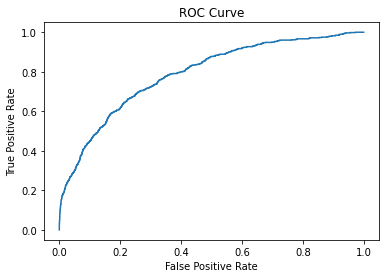

In [ ]:
plt.plot(fpr_lgb, tpr_lgb)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(prob_df['Lock'],prob_df['propensity'] , average='macro')

0.7889751484138264

In [ ]:
prob_df.head()

,LeadID,propensity,Lock
0,498944.0,0.001819,0.0
1,214193.0,0.000387,0.0
2,318641.0,0.008112,0.0
3,339947.0,0.030948,0.0
4,223470.0,0.684383,0.0


In [ ]:
prob_df = prob_df.sort_values(by='propensity',ascending=False)
prob_df.head()

,LeadID,propensity,Lock
14847,257004.0,0.988717,1.0
12259,324301.0,0.987774,0.0
1901,326587.0,0.978234,1.0
25362,410073.0,0.978125,1.0
23198,536407.0,0.974944,1.0


In [ ]:
def get_gains(data):
    
    # Add row ids 
    # Add decile
    data['row_id'] = range(0,0+len(data))
    data['decile'] = ( data['row_id'] / (len(data)/10) ).astype(int)
    data.head()
    
    # Check the count by decile
    data.loc[data['decile'] == 10]=9
    data['decile'].value_counts()
    
    #create gains table
    data['decile'] = data['decile']+1
    gains = data.groupby('decile').agg({'Lock':['count','sum'],
                                        'propensity':['min','max','mean']}).reset_index()
    gains.columns = ['decile','count','actual_locks','min_prob','max_prob','avg_prob']
    gains
    
    #add metrics to the gains table
    gains['non_actual_locks'] = gains['count'] - gains['actual_locks']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual_locks'].cumsum()
    gains['cum_non_actual'] = gains['non_actual_locks'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual'] ) * 100
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains = pd.DataFrame(gains)
    return gains

In [ ]:
get_gains(prob_df)

,decile,count,actual_locks,min_prob,max_prob,avg_prob,non_actual_locks,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,K_S,lift
0,1,3759,265.0,0.419428,0.988717,0.607810,3494.0,3759,265.0,3494.0,0.44,0.09,60.3,35.0,4.39
1,2,3758,101.0,0.229738,0.419101,0.315278,3657.0,7517,366.0,7151.0,0.61,0.19,120.6,42.0,3.03
2,3,3759,67.0,0.132419,0.229732,0.176475,3692.0,11276,433.0,10843.0,0.72,0.29,180.9,43.0,2.39
3,4,3758,47.0,0.077729,0.132396,0.102426,3711.0,15034,480.0,14554.0,0.80,0.39,241.2,41.0,1.99
4,5,3759,46.0,0.044947,0.077729,0.059931,3713.0,18793,526.0,18267.0,0.87,0.49,301.5,38.0,1.74
5,6,3758,27.0,0.025891,0.044946,0.034600,3731.0,22551,553.0,21998.0,0.92,0.59,361.8,33.0,1.53
6,7,3759,19.0,0.014025,0.025890,0.019511,3740.0,26310,572.0,25738.0,0.95,0.70,422.1,25.0,1.36
7,8,3758,11.0,0.006609,0.014024,0.009981,3747.0,30068,583.0,29485.0,0.97,0.80,482.4,17.0,1.21
8,9,3759,9.0,0.002252,0.006609,0.004256,3750.0,33827,592.0,33235.0,0.98,0.90,542.7,8.0,1.09
9,10,3758,11.0,0.000003,0.002252,0.000991,3747.0,37585,603.0,36982.0,1.00,1.00,603.0,0.0,1.00


In [ ]:
import scikitplot as skplt
def gain_plot(y,probs):
    
    final_prob_df  = pd.DataFrame({'0': 1-probs,'1':probs})
    
    skplt.metrics.plot_cumulative_gain(y,final_prob_df)
    plt.show()

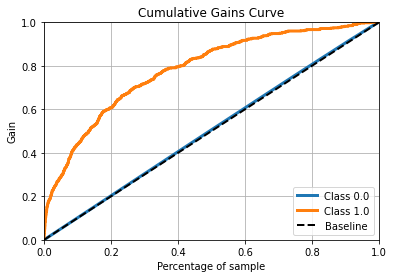

In [ ]:
gain_plot(prob_df['Lock'], prob_df['propensity'])

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

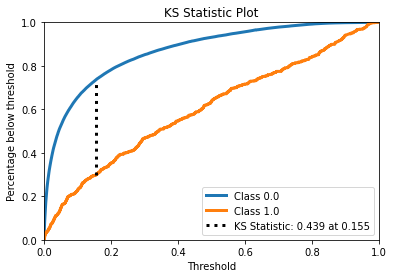

In [ ]:
import scikitplot as skplt
final_prob_df_test  = pd.DataFrame({'0': 1-prob_df['propensity'],'1':prob_df['propensity']})
skplt.metrics.plot_ks_statistic(prob_df['Lock'], final_prob_df_test)

In [ ]:
print(prob_df[prob_df['Lock']==1]['propensity'].mean())
print(prob_df[prob_df['Lock']==0]['propensity'].mean())

0.3974034030273442
0.1288221630990455


<AxesSubplot:xlabel='Lock', ylabel='propensity'>

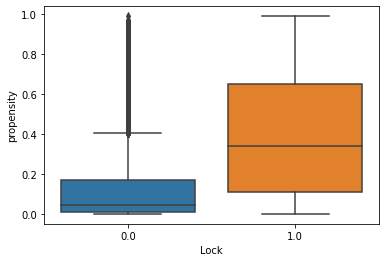

In [ ]:
sns.boxplot(y=prob_df['propensity'],x=prob_df['Lock'])

In [ ]:
df_test_copy['Lock'].value_counts()

0.0    36982
1.0      603
Name: Lock, dtype: int64

In [ ]:
prob_df.shape

(37585, 5)

In [ ]:
prob_df[prob_df['propensity']==0].shape

(0, 5)

In [ ]:
test_preds['LeadID'].nunique()

37585

### Saving the model to .pkl file

In [ ]:
#dump the pipeline to pickle file
import pickle
filename = 'BM_Propensity_Preprocess_Model_Pipeline_Rerun.pkl'
pickle.dump(pipe_fit, open(filename, 'wb'))

## Feature Importance

In [ ]:
from sklearn.pipeline import Pipeline
data_pipe = Pipeline([('get_cols', get_needed_columns(original_features)),
('columntype', ColumnTypeChange_Imputation(num_cols,cat_cols)),
('initial_preprocessing', preprocess_columns('Bankruptcy','Number of Buildings','Property Type Indicator','Number of Stories in Building','Mortgage Term')),
('outlier', outlier_removal(outlier_cols)),
('others_cat', minor_cat(cat_cols)),
('date_f', date_transform(date_cols)),
('ordinal', ordinal_cat('SelfCreditRating',ordinal_asc,ordinal_desc)),
('impute_mean', mean_imputation(impute_mean_cols)),
('impute_cat', cat_imputation(mode,non_mode,bool_cols)),
('target_encode', target_encoding(cat_cols))])

data_pipe_df = data_pipe.fit_transform(df_train_copy,df_train_copy['Lock'])
data_pipe_df.shape

(150336, 92)

In [ ]:
data_pipe_df.head()

,LeadID,ID Verify Score,DesiredNewLoanAmount,UnpaidPrincipalBalance,CurrentPropertyValue,IsMilitary,Demographic Level,Median Years of School,Median Year Built,Length of Residence,Mortgage Amount,Loan To Value,Sale Type,Tax Amount,Number of Bathrooms,Living Squarefeet,Land Squarefeet,Year Built,PropertyState,LeadSource,CampaignID,Bankruptcy,LoanRequestType,Phone Type,Mail Order Respondent,Median House Value,Dwelling Type,Homeowner,Mortgage Term,Mortgage Deed Type,Mortgage Type,Last Assessment Year,Deed Type,Tax Year,Square foot type indicator,Improvement Value Indicator,Number of Stories in Building,Number of Buildings,Property Type Indicator,Residential Based,Absentee Owner Indicator,Land Use code,Penetration Range Blue Collar,Penetration Range Other Occupation,Penetration Range White Collar,Percent Range Automobile Owner,Home Market Value,Estimated Household Income,Wealth Score,SelfCreditRating,Mortgage Due Month,Mortgage Due Dayofweek,Mortgage Due Is_month_end,Mortgage Due Is_month_start,Mortgage Due Is_quarter_end,Mortgage Due Is_quarter_start,Mortgage Due Is_year_end,Mortgage Due Is_year_start,Mortgage Due Is_weekend,Mortgage Due Week_of_month,Mortgage Due Decade,Mortgage Month,Mortgage Dayofweek,Mortgage Is_month_end,Mortgage Is_month_start,Mortgage Is_quarter_end,Mortgage Is_quarter_start,Mortgage Is_year_end,Mortgage Is_year_start,Mortgage Is_weekend,Mortgage Week_of_month,Mortgage Decade,Recording Month,Recording Dayofweek,Recording Is_month_end,Recording Is_month_start,Recording Is_quarter_end,Recording Is_quarter_start,Recording Is_year_end,Recording Is_year_start,Recording Is_weekend,Recording Week_of_month,Recording Decade,self_credit_rating_ordinal,Home Market Value_ordinal,Estimated Household Income_ordinal,Wealth Score_ordinal,Penetration Range Blue Collar_ordinal,Penetration Range Other Occupation_ordinal,Penetration Range White Collar_ordinal,Percent Range Automobile Owner_ordinal,target
176076,489501.0,84.0,190000.0,190000.0,350000.0,1.650115,1.626167,117.000000,1976.6226,11.000000,205603.625214,69.943545,1.614282,4.025348e+05,246.261178,2061.474995,31115.765018,1983.18798,1.719618,1.505063,2.348536,1.60825,1.603741,1.246528,1.571158,2.083940,1.625922,1.611552,1.390409,1.627773,1.44119,1.483121,1.603437,1.662927,1.605914,1.678868,1.560207,1.593796,1.685957,1.59512,1.640286,1.639665,1.838101,1.686081,1.817220,1.607677,1.404239,1.890358,1.517788,0.698233,6.607114,3.041376,0,0,0,0,0,0,0,1.246892,203.742356,6.644045,2.336856,0,0,0,0,0,0,0,3.341992,200.938924,6.65904,2.090783,0,0,0,0,0,0,0,3.229422,200.568793,4.0,9.702065,5.000000,5.391347,5.000000,9.000000,6.000000,13.000000,0.0
113413,565617.0,100.0,125000.0,75000.0,350000.0,1.650115,1.626167,117.000000,2007.0000,2.000000,159900.000000,69.943545,1.614282,1.145000e+05,300.000000,3496.000000,166835.000000,2007.00000,1.526699,1.842569,1.984205,1.60825,1.603741,1.659163,1.663231,2.244824,1.625922,1.611552,1.728919,1.627773,1.44119,1.952711,1.603437,1.662927,1.605914,1.491047,1.374631,1.597387,1.619212,1.59512,1.640286,1.639665,1.838101,1.686081,1.772068,1.607677,1.164628,1.736580,1.641601,1.643707,2.000000,3.000000,0,1,0,0,0,0,0,1.000000,204.000000,1.000000,4.000000,0,0,0,0,0,0,0,3.000000,201.000000,6.65904,2.090783,0,0,0,0,0,0,0,3.229422,200.568793,5.0,10.000000,2.000000,6.000000,5.000000,9.000000,7.000000,13.000000,0.0
38741,389196.0,86.0,190000.0,190000.0,350000.0,1.650115,1.626167,112.000000,1958.0000,8.000000,292000.000000,86.000000,1.614282,5.518000e+05,300.000000,1630.000000,43560.000000,1985.00000,2.203164,0.624588,0.656836,1.60825,1.603741,1.246528,1.571158,1.442374,1.625922,1.611552,1.728919,1.627773,1.44119,1.483121,1.603437,1.662927,1.605914,1.451329,1.374631,1.597387,1.619212,1.59512,1.640286,1.639665,2.033166,1.686081,1.817220,1.607677,1.404239,1.789112,1.517788,1.643707,1.000000,0.000000,0,1,0,1,0,1,0,1.000000,203.000000,10.000000,0.000000,1,0,0,0,0,0,0,6.000000,200.000000,10.00000,0.000000,1,0,0,0,0,0,0,6.000000,200.000000,5.0,9.702065,6.000000,5.391

In [ ]:
data_pipe_df.columns

Index(['LeadID', 'ID Verify Score', 'DesiredNewLoanAmount',
       'UnpaidPrincipalBalance', 'CurrentPropertyValue', 'IsMilitary',
       'Demographic Level', 'Median Years of School', 'Median Year Built',
       'Length of Residence', 'Mortgage Amount', 'Loan To Value', 'Sale Type',
       'Tax Amount', 'Number of Bathrooms', 'Living Squarefeet',
       'Land Squarefeet', 'Year Built', 'PropertyState', 'LeadSource',
       'CampaignID', 'Bankruptcy', 'LoanRequestType', 'Phone Type',
       'Mail Order Respondent', 'Median House Value', 'Dwelling Type',
       'Homeowner', 'Mortgage Term', 'Mortgage Deed Type', 'Mortgage Type',
       'Last Assessment Year', 'Deed Type', 'Tax Year',
       'Square foot type indicator', 'Improvement Value Indicator',
       'Number of Stories in Building', 'Number of Buildings',
       'Property Type Indicator', 'Residential Based',
       'Absentee Owner Indicator', 'Land Use code',
       'Penetration Range Blue Collar', 'Penetration Range Other Occup

In [ ]:
train_data = data_pipe_df.drop(['LeadID', 'ID Verify Score', 'target'], axis=1)
y = data_pipe_df['target']

In [ ]:
train_data.shape, y.shape

((150336, 89), (150336,))

In [ ]:
train_data.head()

,DesiredNewLoanAmount,UnpaidPrincipalBalance,CurrentPropertyValue,IsMilitary,Demographic Level,Median Years of School,Median Year Built,Length of Residence,Mortgage Amount,Loan To Value,Sale Type,Tax Amount,Number of Bathrooms,Living Squarefeet,Land Squarefeet,Year Built,PropertyState,LeadSource,CampaignID,Bankruptcy,LoanRequestType,Phone Type,Mail Order Respondent,Median House Value,Dwelling Type,Homeowner,Mortgage Term,Mortgage Deed Type,Mortgage Type,Last Assessment Year,Deed Type,Tax Year,Square foot type indicator,Improvement Value Indicator,Number of Stories in Building,Number of Buildings,Property Type Indicator,Residential Based,Absentee Owner Indicator,Land Use code,Penetration Range Blue Collar,Penetration Range Other Occupation,Penetration Range White Collar,Percent Range Automobile Owner,Home Market Value,Estimated Household Income,Wealth Score,SelfCreditRating,Mortgage Due Month,Mortgage Due Dayofweek,Mortgage Due Is_month_end,Mortgage Due Is_month_start,Mortgage Due Is_quarter_end,Mortgage Due Is_quarter_start,Mortgage Due Is_year_end,Mortgage Due Is_year_start,Mortgage Due Is_weekend,Mortgage Due Week_of_month,Mortgage Due Decade,Mortgage Month,Mortgage Dayofweek,Mortgage Is_month_end,Mortgage Is_month_start,Mortgage Is_quarter_end,Mortgage Is_quarter_start,Mortgage Is_year_end,Mortgage Is_year_start,Mortgage Is_weekend,Mortgage Week_of_month,Mortgage Decade,Recording Month,Recording Dayofweek,Recording Is_month_end,Recording Is_month_start,Recording Is_quarter_end,Recording Is_quarter_start,Recording Is_year_end,Recording Is_year_start,Recording Is_weekend,Recording Week_of_month,Recording Decade,self_credit_rating_ordinal,Home Market Value_ordinal,Estimated Household Income_ordinal,Wealth Score_ordinal,Penetration Range Blue Collar_ordinal,Penetration Range Other Occupation_ordinal,Penetration Range White Collar_ordinal,Percent Range Automobile Owner_ordinal
176076,190000.0,190000.0,350000.0,1.650115,1.626167,117.000000,1976.6226,11.000000,205603.625214,69.943545,1.614282,4.025348e+05,246.261178,2061.474995,31115.765018,1983.18798,1.719618,1.505063,2.348536,1.60825,1.603741,1.246528,1.571158,2.083940,1.625922,1.611552,1.390409,1.627773,1.44119,1.483121,1.603437,1.662927,1.605914,1.678868,1.560207,1.593796,1.685957,1.59512,1.640286,1.639665,1.838101,1.686081,1.817220,1.607677,1.404239,1.890358,1.517788,0.698233,6.607114,3.041376,0,0,0,0,0,0,0,1.246892,203.742356,6.644045,2.336856,0,0,0,0,0,0,0,3.341992,200.938924,6.65904,2.090783,0,0,0,0,0,0,0,3.229422,200.568793,4.0,9.702065,5.000000,5.391347,5.000000,9.000000,6.000000,13.000000
113413,125000.0,75000.0,350000.0,1.650115,1.626167,117.000000,2007.0000,2.000000,159900.000000,69.943545,1.614282,1.145000e+05,300.000000,3496.000000,166835.000000,2007.00000,1.526699,1.842569,1.984205,1.60825,1.603741,1.659163,1.663231,2.244824,1.625922,1.611552,1.728919,1.627773,1.44119,1.952711,1.603437,1.662927,1.605914,1.491047,1.374631,1.597387,1.619212,1.59512,1.640286,1.639665,1.838101,1.686081,1.772068,1.607677,1.164628,1.736580,1.641601,1.643707,2.000000,3.000000,0,1,0,0,0,0,0,1.000000,204.000000,1.000000,4.000000,0,0,0,0,0,0,0,3.000000,201.000000,6.65904,2.090783,0,0,0,0,0,0,0,3.229422,200.568793,5.0,10.000000,2.000000,6.000000,5.000000,9.000000,7.000000,13.000000
38741,190000.0,190000.0,350000.0,1.650115,1.626167,112.000000,1958.0000,8.000000,292000.000000,86.000000,1.614282,5.518000e+05,300.000000,1630.000000,43560.000000,1985.00000,2.203164,0.624588,0.656836,1.60825,1.603741,1.246528,1.571158,1.442374,1.625922,1.611552,1.728919,1.627773,1.44119,1.483121,1.603437,1.662927,1.605914,1.451329,1.374631,1.597387,1.619212,1.59512,1.640286,1.639665,2.033166,1.686081,1.817220,1.607677,1.404239,1.789112,1.517788,1.643707,1.000000,0.000000,0,1,0,1,0,1,0,1.000000,203.000000,10.000000,0.000000,1,0,0,0,0,0,0,6.000000,200.000000,10.00000,0.000000,1,0,0,0,0,0,0,6.000000,200.000000,5.0,9.702065,6.000000,5.391347,6.000000,9.000000,6.000000,13.000000
625,270000.0,270000.0,725000.0,1.650115,

In [ ]:
lgbm = LGBMClassifier(n_estimators=845,
                             metric=  'auc',
                             max_depth= 5,
                             learning_rate= 0.10244824551149534,
                             min_data_in_leaf= 80,
                             num_leaves= 38,
                             bagging_fraction= 0.856958665167685,
                             feature_fraction= 0.3086053447141449,
                             is_unbalance= True,
                             bagging_freq= 8,
                             bagging_seed= 12345,
                             lambda_l1 = 0.5879295423261183,
                             lambda_l2 = 1.8924148301563073,
                             min_split_gain = 0.07321862315023188,
                             min_child_weight = 37.67028128497241)
lgbm_model = lgbm.fit(train_data,y)

[LightGBM] [Warning] lambda_l1 is set=0.5879295423261183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5879295423261183
[LightGBM] [Warning] lambda_l2 is set=1.8924148301563073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8924148301563073
[LightGBM] [Warning] feature_fraction is set=0.3086053447141449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3086053447141449
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.856958665167685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856958665167685


In [ ]:
fea_imp = pd.DataFrame(sorted(zip(train_data.columns,lgbm_model.feature_importances_)), columns=['col','imp'])
fea_imp = fea_imp.sort_values('imp', ascending=False)
fea_imp.head(30)

,col,imp
15,Land Squarefeet,944
82,Tax Amount,933
3,CurrentPropertyValue,861
20,Living Squarefeet,858
27,Mortgage Amount,777
25,Median Year Built,742
84,UnpaidPrincipalBalance,741
6,DesiredNewLoanAmount,691
21,Loan To Value,683
87,Year Built,682


In [ ]:
#train and test set splitting - Stratified
train_train,train_val = train_test_split(data_pipe_df,stratify=data_pipe_df['target'], test_size=0.2, random_state = 10)
train_train.shape, train_val.shape

((120268, 92), (30068, 92))

In [ ]:
train_train['target'].value_counts(normalize=True)*100

0.0    98.396082
1.0     1.603918
Name: target, dtype: float64

In [ ]:
df_train_pt = train_train.copy(deep=True)
df_train_pt.shape

(120268, 92)

In [ ]:
df_train_pt.head()

,LeadID,ID Verify Score,DesiredNewLoanAmount,UnpaidPrincipalBalance,CurrentPropertyValue,IsMilitary,Demographic Level,Median Years of School,Median Year Built,Length of Residence,Mortgage Amount,Loan To Value,Sale Type,Tax Amount,Number of Bathrooms,Living Squarefeet,Land Squarefeet,Year Built,PropertyState,LeadSource,CampaignID,Bankruptcy,LoanRequestType,Phone Type,Mail Order Respondent,Median House Value,Dwelling Type,Homeowner,Mortgage Term,Mortgage Deed Type,Mortgage Type,Last Assessment Year,Deed Type,Tax Year,Square foot type indicator,Improvement Value Indicator,Number of Stories in Building,Number of Buildings,Property Type Indicator,Residential Based,Absentee Owner Indicator,Land Use code,Penetration Range Blue Collar,Penetration Range Other Occupation,Penetration Range White Collar,Percent Range Automobile Owner,Home Market Value,Estimated Household Income,Wealth Score,SelfCreditRating,Mortgage Due Month,Mortgage Due Dayofweek,Mortgage Due Is_month_end,Mortgage Due Is_month_start,Mortgage Due Is_quarter_end,Mortgage Due Is_quarter_start,Mortgage Due Is_year_end,Mortgage Due Is_year_start,Mortgage Due Is_weekend,Mortgage Due Week_of_month,Mortgage Due Decade,Mortgage Month,Mortgage Dayofweek,Mortgage Is_month_end,Mortgage Is_month_start,Mortgage Is_quarter_end,Mortgage Is_quarter_start,Mortgage Is_year_end,Mortgage Is_year_start,Mortgage Is_weekend,Mortgage Week_of_month,Mortgage Decade,Recording Month,Recording Dayofweek,Recording Is_month_end,Recording Is_month_start,Recording Is_quarter_end,Recording Is_quarter_start,Recording Is_year_end,Recording Is_year_start,Recording Is_weekend,Recording Week_of_month,Recording Decade,self_credit_rating_ordinal,Home Market Value_ordinal,Estimated Household Income_ordinal,Wealth Score_ordinal,Penetration Range Blue Collar_ordinal,Penetration Range Other Occupation_ordinal,Penetration Range White Collar_ordinal,Percent Range Automobile Owner_ordinal,target
160001,442264.0,84.0,216571.83189,330000.0,497000.000000,1.650115,1.626167,123.000000,2005.0000,3.000000,362000.000000,71.000000,1.614282,640300.0,300.000000,2420.0,165851.0,2005.0,1.470141,3.952128,3.952128,1.60825,1.603741,1.659163,1.665889,1.442374,1.625922,1.611552,1.728919,1.488892,1.441190,1.483121,1.603437,1.662927,1.605914,1.451329,1.374631,1.597387,1.619212,1.59512,1.640286,1.639665,1.219466,1.620057,1.424407,1.607677,2.392090,1.789112,1.641601,1.643707,8.000000,4.000000,0,1,0,0,0,0,0,1.000000,204.000000,7.000000,2.000000,0,0,0,0,0,0,0,4.000000,201.000000,9.0,0.0,0,0,0,0,0,0,0,5.0,201.0,5.0,5.000000,6.000000,6.000000,2.000000,8.000000,11.000000,13.000000,0.0
182998,221747.0,71.0,140000.00000,140000.0,374929.210555,1.650115,1.626167,149.000000,1983.0000,7.000000,119920.000000,84.000000,1.614282,87054.0,200.000000,2150.0,20473.0,1983.0,2.185027,1.505063,0.607660,1.60825,1.603741,1.659163,1.883441,1.442374,1.625922,1.611552,1.728919,2.172774,2.629923,1.483121,1.603437,1.002420,1.605914,1.740176,1.774084,1.597387,1.619212,1.59512,1.640286,1.639665,1.454942,1.482432,1.424407,1.607677,2.392090,1.890358,1.641601,1.643707,8.000000,0.000000,0,1,0,0,0,0,0,1.000000,203.000000,7.000000,0.000000,0,0,0,0,0,0,0,2.000000,200.000000,3.0,4.0,1,0,1,0,0,0,0,5.0,200.0,5.0,5.000000,5.000000,6.000000,3.000000,7.000000,11.000000,13.000000,0.0
30394,468415.0,97.0,155000.00000,150000.0,210000.000000,1.650115,1.626167,122.000000,2008.0000,5.000000,149150.000000,75.000000,1.560457,244569.0,200.000000,2429.0,8276.0,2008.0,2.445930,1.332620,0.444597,1.60825,1.603741,1.659163,1.413697,2.244824,1.625922,1.611552,1.728919,1.627773,1.441190,1.952711,1.603437,1.662927,1.605914,1.740176,1.464854,1.597387,1.619212,1.59512,1.640286,1.639665,1.838101,1.620057,1.794223,1.607677,2.345879,1.789112,2.112842,0.698233,5.000000,1.000000,0,1,0,0,0,0,0,1.000000,204.000000,4.000000,4.000000,0,0,0,0,0,0,0,4.000000,201.000000,4.0,4.0,0,0,0,0,0,0,0,4.0,201.0,4.0,6.000000,6.000000,3.000000,5.000000,8.000000,8.000000,13.000000,0.0
72384,474262.0,95.0,175000.00000,175000.

In [ ]:
df_train_pt.isnull().mean()*100

LeadID                                        0.0
ID Verify Score                               0.0
DesiredNewLoanAmount                          0.0
UnpaidPrincipalBalance                        0.0
CurrentPropertyValue                          0.0
IsMilitary                                    0.0
Demographic Level                             0.0
Median Years of School                        0.0
Median Year Built                             0.0
Length of Residence                           0.0
Mortgage Amount                               0.0
Loan To Value                                 0.0
Sale Type                                     0.0
Tax Amount                                    0.0
Number of Bathrooms                           0.0
Living Squarefeet                             0.0
Land Squarefeet                               0.0
Year Built                                    0.0
PropertyState                                 0.0
LeadSource                                    0.0


In [ ]:
y_train_pt = train_train['target']

In [ ]:
y_train_pt.isnull().mean()*100

0.0

In [ ]:
#for encoded version
random_seed = 12345
train_data = lgb.Dataset(data = df_train_pt, label = y_train_pt)
##categorical_features and free_raw_data should be used only when we are keeping categorical as it is
def lgb_eval(num_iterations,num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight,learning_rate,min_data_in_leaf,bagging_freq):
    params = {'application':'binary', 'learning_rate':0.01, 'early_stopping_round':100, 
              'feature_pre_filter':False,'metric':'auc'} #f_roc_auc for roc_auc
    params['num_iterations'] = int(num_iterations)
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    params['learning_rate'] = learning_rate
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['bagging_freq'] = int(round(bagging_freq))
    cv_result = lgb.cv(params, train_data, nfold=10, seed=random_seed, stratified=True, verbose_eval =200, metrics = ['auc']) #feval = f_roc_auc for roc_auc isntead of metrics = ['auc']
    return max(cv_result['auc-mean'])#'roc_auc_mean' for roc_auc

In [ ]:
from bayes_opt import BayesianOptimization
lgbBO = BayesianOptimization(lgb_eval, {'num_iterations': (10,5000),
                                        'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 8.99),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50), 
                                        'learning_rate' : (0,1),
                                        'min_data_in_leaf' : (50,200),
                                        'bagging_freq' : (1,10)
                                       },
                                        
                             random_state=0)

In [ ]:
lgbBO.maximize(init_points=10, n_iter=15)

|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | min_sp... | num_it... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1736, number of negative: 106505
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2904
[LightGBM] [Info] Number of data points in the train set: 108241, number of used features: 92
[LightGBM] [Info] Number of positive: 1736, number of negative: 106505
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of test

ValueError: array must not contain infs or NaNs

In [ ]:
parameters = lgbBO.max['params']

In [ ]:
parameters['num_iterations']

In [ ]:
parameters